In [5]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
sys.path.append('../../../src/')

from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# custom scripts
from helpers import calculate_psnr, calculate_ser, calculate_ssim

layout = go.Layout(template="plotly_dark")
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
py.init_notebook_mode()

In [7]:
DATA_PATH = '../../../data/FastMRIData/singlecoil_train/'
FILE_SAMPLE = DATA_PATH + 'file1001287.h5'

hf = h5py.File(FILE_SAMPLE, mode='r')
list(hf.keys())
dict(hf.attrs)

['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']

{'acquisition': 'CORPD_FBK',
 'max': 0.0004624860345092124,
 'norm': 0.1396935333699368,
 'patient_id': '6999a1ffb63756b29125b8779ce2c956620ff82c62700fe687d4a0d823b066b8'}

In [9]:
TEST_PATH = '../../../data/FastMRIData/singlecoil_test_v2/'
TEST_FILE_SAMPLE = TEST_PATH + 'file1000417_v2.h5'

test_hf = h5py.File(TEST_FILE_SAMPLE, mode='r')
list(test_hf.keys())
dict(test_hf.attrs)

['ismrmrd_header', 'kspace', 'mask']

{'acceleration': 8,
 'acquisition': 'CORPDFS_FBK',
 'num_low_frequency': 15,
 'patient_id': 'dfa0e42dbaa4fb797ef58c54145c5bc562e88cd51a5adf95907e76104dc9f920'}

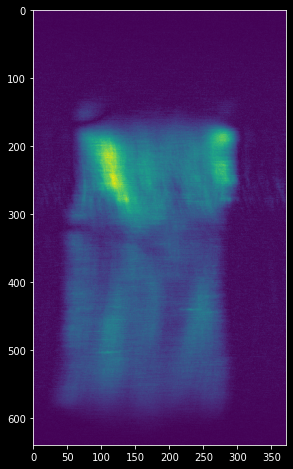

In [20]:
slice_n = -1

exmp = test_hf['kspace'][()][slice_n]
plt.imshow(np.abs(np.fft.ifftshift(np.fft.ifft2(exmp))))

In [27]:
mask.shape

(372,)

# Number of slices x height x width

In [23]:
volume_kspace = hf['kspace'][()]
volume_kspace.shape
volume_kspace.dtype

mask = test_hf['mask'][()]

_, rows, cols = volume_kspace.shape
print(f'rows: {rows} cols: {cols}')

(32, 640, 372)

dtype('complex64')

rows: 640 cols: 372


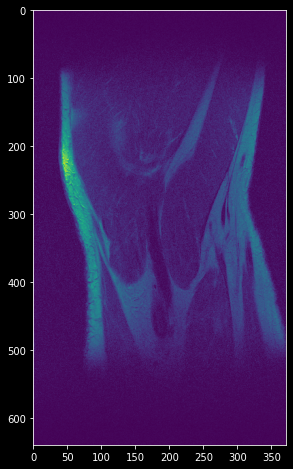

In [25]:
plt.imshow(np.abs(np.fft.ifftshift(np.fft.ifft2(volume_kspace[slice_n]))))

In [28]:
rows, cols = (640, 320)

def get_mask(mask, rows, cols):
    zeros = np.where(mask == 0)[0]
    ones = np.where(mask == 1)[0]
    
    masked_array = np.zeros((rows, cols))
    masked_array[:, zeros] = 0
    masked_array[:, ones] = 1
    return masked_array

def get_b(coil_matrix, samples_rows):
    B = np.fft.ifftshift(coil_matrix).flatten()[samples_rows]
    return B

def pipeline(multicoil_kspace_measurement, mask):
    matrix_mask = get_mask(mask, rows, cols)
    samples_rows = np.where(np.fft.ifftshift(matrix_mask).flatten())[0]
    Bs = []

    for coil in multicoil_kspace_measurement:
        Bs.append(get_b(coil, samples_rows))

    return matrix_mask, samples_rows, np.array(Bs)

# Produce B for each coil matrix

In [19]:
matrix_mask, samples_rows, Bs = pipeline(volume_kspace[10], mask)
matrix_mask.shape
samples_rows.shape
Bs.shape
Bs[0].size / volume_kspace[10][-1].size

(640, 320)

(25600,)

(20, 25600)

0.125

(25600,)

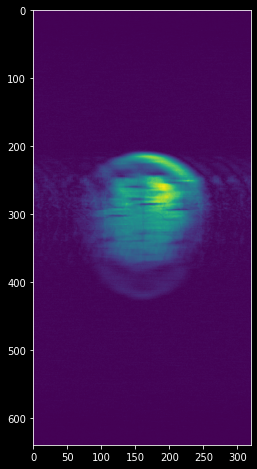

In [20]:
def zero_fill(b, samples_rows, rows, cols):
    zero_filled = np.zeros((rows * cols), dtype="complex128")
    zero_filled[samples_rows] = b
    zero_filled = np.reshape(zero_filled, (rows, cols))
    zero_filled = np.fft.ifft2(zero_filled)
    zero_filled = np.fft.fftshift(zero_filled)
    return zero_filled

Bs[-1].shape
zero_filled = zero_fill(Bs[-1], samples_rows, rows, cols)
plt.imshow(np.abs(zero_filled))

25600

25600

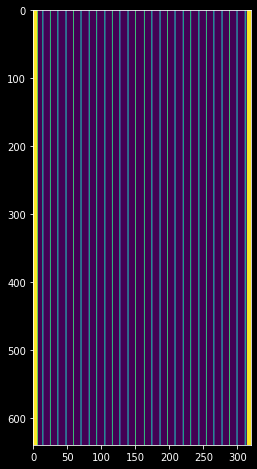

In [21]:
samples_rows.size
np.unique(samples_rows).size

# plt.imshow(np.where(rss_recon, matrix_mask ==1))
test = np.zeros((rows * cols))
test[samples_rows] = 1
test = np.reshape(test, (rows, cols))
# test = np.fft.fftshift(test)
plt.imshow(test)

# Save Matlab copies for reproduction

In [18]:
from scipy.io import savemat

MRI_data = {
    "Bs": Bs,
    "samples_rows": samples_rows,
    "matrix_mask": matrix_mask,
    "reconstructed_rss": rss_recon[10]
}
# samples_rows_mat = {"samples_rows": samples_rows}

savemat("mri_data.mat", MRI_data)
# savemat("b.mat", B_mat)

# Filters for pre-filtering

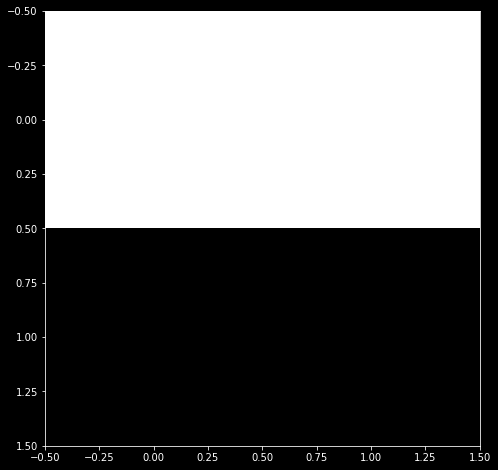

In [22]:
filter1 = np.array([[1, 1], [-1, -1]])
filter2 = filter1.copy().T
filter3 = np.array([[1, -1], [-1, 1]])

initial_filters = [filter1, filter2, filter3]
_ = plt.imshow(initial_filters[0], cmap="gray")

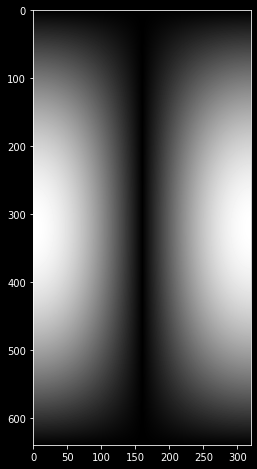

In [52]:
filters = [np.fft.fft2(f, s=(rows, cols)) for f in initial_filters]
_ = plt.imshow(np.abs(filters[0]), cmap="gray")

In [24]:
stacked_image_size = rows * cols

# reconstrucao do sinal a partir das medidas
A_ = lambda x: np.fft.fft2(np.reshape(x, (rows, cols))).flatten()[samples_rows]

def ah(x):
    x = fill_with_zeros(x, samples_rows, stacked_image_size)
    x = np.fft.ifft2(x)
    x = x * (rows * cols)
    x = x.flatten()
    return x

def fill_with_zeros(x, samples_rows, stacked_image_size):
    y = np.zeros((stacked_image_size), dtype=complex)

    y[samples_rows] = x
    y = np.reshape(y, (rows, cols))
    return y

In [26]:
from importlib import reload
import mri_cs
reload(mri_cs)

b = Bs[-1]

recons = []

recons.append(mri_cs.lpminimization(A_, ah, b, N=stacked_image_size, tol_cg=1e-6, maxiter_cg=2*b.size))

<module 'mri_cs' from '../../src/mri_cs.py'>

Starting stage 1
    Iteration 1
Starting stage 2
    Iteration 1
Starting stage 3
    Iteration 1
Starting stage 4
    Iteration 1
Starting stage 5
    Iteration 1
Starting stage 6
    Iteration 1
Starting stage 7
    Iteration 1
Starting stage 8
    Iteration 1
Starting stage 9
    Iteration 1
Starting stage 10
    Iteration 1
    Iteration 2


# Prefiltering L1 Minimization

In [47]:
# from importlib import reload
# reload(mri_cs)
import mri_cs
recons = []

for b in tqdm([Bs[-1]]):
    recons.append(mri_cs.prefiltering(samples_rows, b, rows, cols, h=initial_filters, tol_cg=1e-6, maxiter_cg=2*b.size, number_jobs=1))

  0%|          | 0/1 [00:00<?, ?it/s]

####### Reconstructing filtered image 1 of 3 #######
Starting stage 1 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Starting stage 2 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Starting stage 3 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Starting stage 4 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Starting stage 5 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Starting stage 6 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Starting stage 7 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Starting stage 8 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Starting stage 9 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Starting stage 10 (image 1 of 3)
    Iteration 1 (image 1 of 3)
Finished reconstructing filtered image 1 of 3
####### Reconstructing filtered image 2 of 3 #######
Starting stage 1 (image 2 of 3)
    Iteration 1 (image 2 of 3)
Starting stage 2 (image 2 of 3)
    Iteration 1 (image 2 of 3)
Starting stage 3 (image 2 of 3)
    Iteration 1 (image 2 of 3)
Starting stage 4 (image 2 of

100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


In [147]:
# recon = recons[0]
# recon[samples_rows].shape
# test = np.fft.ifftshift(volume_kspace[10][0].flatten()[samples_rows])
# test.shape

# recon[samples_rows] == volume_kspace[10][0].flatten()[samples_rows]
# list(zip(recon.flatten()[:10], test.flatten()[:5]))

(25600,)

(25600,)

array([False, False, False, ..., False, False, False])

[((1.1376176871635837e-08+8.319066182593815e-09j), 0j),
 ((6.959701695136176e-09+1.1145900348691556e-08j), 0j),
 ((7.78293478125349e-09+1.3271106743227664e-08j), 0j),
 ((1.0041256332595205e-08+1.3311891204406042e-08j), 0j),
 ((8.842791819053315e-09+1.3135858510820813e-08j), 0j)]

In [48]:
# reconstructed = combined.copy()
recon = recons[0].copy()
recon = np.reshape(recon, (rows, cols))
# recon = np.fft.ifft2(recon)
recon = np.fft.ifftshift(recon)

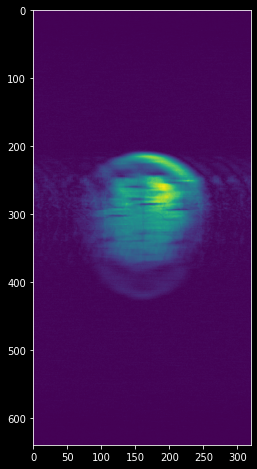

In [43]:
plt.imshow(np.abs(np.fft.fftshift(np.fft.ifft2(volume_kspace[10][-1] * mask))))

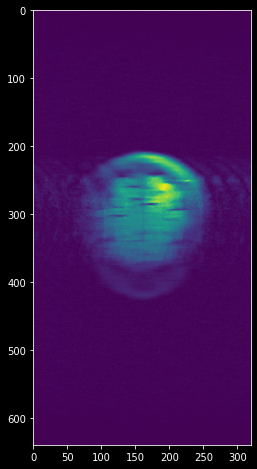

In [49]:
# px.imshow(np.abs(recon), color_continuous_scale="ViRiDis")
plt.imshow(np.abs(recon))

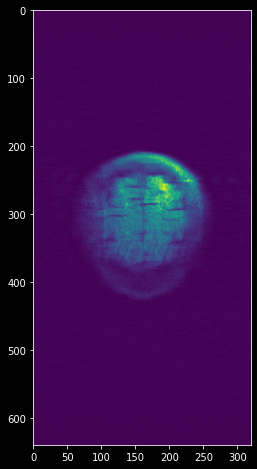

In [31]:
# px.imshow(np.abs(recon), color_continuous_scale="ViRiDis")
plt.imshow(np.abs(recon))

In [136]:
test = np.fft.ifftshift(volume_kspace[10][0] * matrix_mask)
# test = volume_kspace[10][0] * matrix_mask
recon_test = np.fft.fft2(np.fft.fftshift(recon))

test.shape
recon_test.shape
(test.flatten()[samples_rows] == recon_test.flatten()[samples_rows])[:10]

(640, 320)

(640, 320)

array([ True, False,  True, False, False, False, False, False, False,
       False])

In [123]:
(Bs[0] == test.flatten()[samples_rows]).all()

True

In [137]:
list(zip(recon_test.flatten()[:10], test.flatten()[:5]))

[((-2.2782478481531143e-06+0.0002622788306325674j),
  (-2.2782478481531143e-06+0.0002622788306325674j)),
 ((-7.351068779826164e-05-0.00020424602553248405j),
  (7.351068779826164e-05+0.00020424602553248405j)),
 ((9.163422510027885e-05+6.51329755783081e-05j),
  (9.163422510027885e-05+6.51329755783081e-05j)),
 ((-4.027714021503926e-05+2.576527185738087e-05j),
  (4.027714021503925e-05-2.5765271857380867e-05j)),
 ((-4.200264811515803e-06-2.4028588086366653e-05j),
  (-4.200264811515808e-06-2.4028588086366653e-05j))]

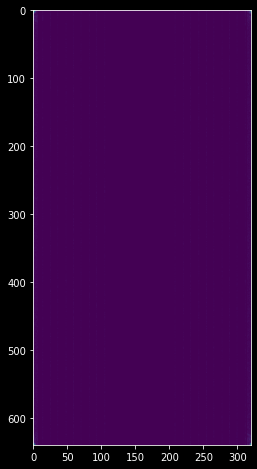

In [115]:
plt.imshow(np.abs(recon_test))

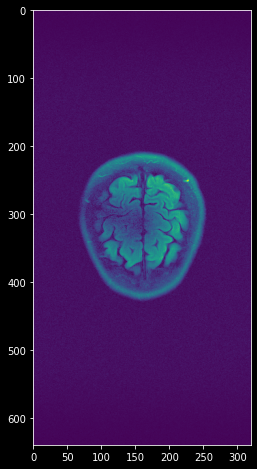

In [137]:
plt.imshow(np.abs(rms(np.fft.fftshift(np.fft.ifft2(volume_kspace[10])))))

In [170]:
A_ = lambda x: np.fft.fft2(np.reshape(x, (rows, cols))).flatten()[samples_rows]
stacked_image_size = rows * cols

def ah(x):
    x = fill_with_zeros(x, samples_rows, stacked_image_size)
    x = np.fft.ifft2(x)
    x = x * (stacked_image_size)
    x = x.flatten()
    return x

def fill_with_zeros(x, samples_rows, stacked_image_size):
    y = np.zeros((stacked_image_size), dtype=complex)

    y[samples_rows] = x
    y = np.reshape(y, (rows, cols))
    return y

x_hat = mri_cs.lpminimization(A_, Ah=ah, b=B, p=1, N=(stacked_image_size), tol_cg=1e-16, maxiter_cg=2*B.size, maxiterperstage=30)

Starting stage 1
    Iteration 1
Starting stage 2
    Iteration 1
Starting stage 3
    Iteration 1
Starting stage 4
    Iteration 1
Starting stage 5
    Iteration 1
Starting stage 6
    Iteration 1
Starting stage 7
    Iteration 1
Starting stage 8
    Iteration 1
    Iteration 2
    Iteration 3
Starting stage 9
    Iteration 1
    Iteration 2
    Iteration 3
Starting stage 10
    Iteration 1
    Iteration 2
    Iteration 3
    Iteration 4


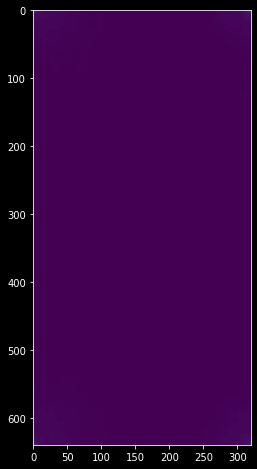

In [171]:
reconstructed_img = x_hat.copy()
reconstructed_img = np.reshape(reconstructed_img, (rows, cols))
plt.imshow(np.abs(reconstructed_img))